## Convert a Trained Scikit-Learn Model to ONNX

The goal of this script is to load the Iris dataset (imported from sklearn datasets), train it, and finally convert to an ONNX format.

### Load and Train Iris Model
1. Load Iris model by importing from sklearn.datasets
2. Display features and labels of dataset
3. Split dataset into Training and Test sets
4. Train model
5. Create prediction from feature set and check accuracy

Reference: RandomForestClassifier()
https://www.datacamp.com/community/tutorials/random-forests-classifier-python

In [8]:
# User Inputs
verboseMode = True
viewNetron = False

In [20]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from matplotlib import pyplot as plt
import os
import pandas as pd
import seaborn as sns

In [13]:
# Script start
print("---- Scikit-Learn to ONNX.ipynb ----\n")

# Load Iris model
iris = load_iris()
print("Iris model loaded!")

# Print target and feature names so we know more about the dataset
print("Displaying model information...\n")
if verboseMode:
    print("Target Names: ", iris.target_names, "\n"
          "Feature Names: ", iris.feature_names, "\n")

    # Create DataFrame of given iris dataset
    print("Displaying example DataFrame...\n")
    data = pd.DataFrame({
        'sepal length':iris.data[:,0],
        'sepal width':iris.data[:,1],
        'petal length':iris.data[:,2],
        'petal width':iris.data[:,3],
        'species':iris.target
    })
    print(data.head())

# Define X as features, y as label (species) then split dataset into training/test set
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Train model on training set and perform predictions on test set
print("\nTraining model...")
model = RandomForestClassifier(n_estimators = 100) # create Gaussian Classifier
model.fit(X_train, y_train) # train model
y_pred = model.predict(X_test)

# Model accuracy
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

# Question: The first time this is run, the accuracy is 1.0, why is this?

---- Scikit-Learn to ONNX.ipynb ----

Iris model loaded!
Displaying model information...

Target Names:  ['setosa' 'versicolor' 'virginica'] 
Feature Names:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'] 

Displaying example DataFrame...

   sepal length  sepal width  petal length  petal width  species
0           5.1          3.5           1.4          0.2        0
1           4.9          3.0           1.4          0.2        0
2           4.7          3.2           1.3          0.2        0
3           4.6          3.1           1.5          0.2        0
4           5.0          3.6           1.4          0.2        0

Training model...
Accuracy:  0.9210526315789473


In [16]:
# Predict for a random set up values
print("[Setosa (1)]", "[Virginica (2)]", "[Versicolor (3)]")
print("Prediction for (3, 5, 4, 2):")
model.predict([[3, 5, 4, 2]])

[Setosa (1)] [Virginica (2)] [Versicolor (3)]
Prediction for (3, 5, 4, 2):


array([1])

In [21]:
# Save Scikit-Learn Model (using Pickle)
import pickle

pklFile = "iris-model.pkl"
with open(pklFile, 'wb') as file:
    pickle.dump(model, file)
    
print("Model saved: ", pklFile, "\n"
      "Directory: ", os.getcwd())

Model saved:  iris-model.pkl 
Directory:  C:\Users\aaram\Desktop\Code 717\Machine Learning\ML Projects\ONNX\Mi2 Tutorials


**Feature Importance (Extra)**

The feature importance referes to a class of techniques for assigning scores to input features to a predictive model indicating the relative importance of each feature when making a prediction.

**CART Feature Importance**
The CART algorithm for feature importance used in scikit-learn is used within the *feature_importances* property allowing you to access the importance scores. These features were generated when running *RandomForestClassifier* above.

Reference: 
https://machinelearningmastery.com/calculate-feature-importance-with-python/

Sklearn Version:  0.23.2


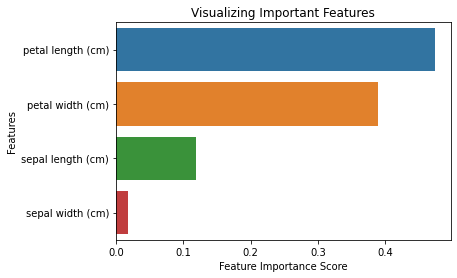

In [18]:
# Visualize the feature importance using seaborn

# Check sklearn version; we need >= 0.22.1
import sklearn
print("Sklearn Version: ", sklearn.__version__)

# Creating a bar plot
feature_imp = pd.Series(model.feature_importances_,index=iris.feature_names).sort_values(ascending=False)
sns.barplot(x = feature_imp, y = feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### Convert Scikit-Learn model to ONNX

This is a very straightforward conversion using skl2onnx.

**Workflow:**
1. The trained iris model, iris-model.pkl imported from sklearn is loaded
2. Datatype converted to Float
3. Scikit-Learn model converted to ONNX via *convert_sklearn* 
4. The output **iris-model.onnx** is saved to the current directory

In [17]:
# Convert into ONNX format
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

modelONNX = "iris-model.onnx"

initial_type = [('float_input', FloatTensorType([None, 4]))]
onnx = convert_sklearn(model, initial_types = initial_type)
with open("iris-model.onnx", "wb") as file:
    file.write(onnx.SerializeToString())
    
print("Model saved: ", modelONNX)

Model saved:  iris-model.onnx


### Use ONNX Runtime for Inference on ONNX model

ONNX Runtime can be used to load any ONNX model for inference. The test dataset is a Numpy array with 3 elements of the Iris dataset (each class of Iris flower).

**Workflow:**
1. An ONNX session is created to run on iris-model.onnx already saved within the working directory.
2. Input and label names are imported via indexing
3. The datatype of the test set is set to FP32 to match input datatype.

In [18]:
import onnxruntime as rt
import numpy

sess = rt.InferenceSession(modelONNX)
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
pred_onnx = sess.run([label_name], {input_name: X_test.astype(numpy.float32)})[0]

print("Input Name: ", input_name)
print("Label Name: ", label_name)

Input Name:  float_input
Label Name:  output_label


In [2]:
# Visualize model within Netron (if you installed)
if viewNetron:
    import netron
    netron.start(modelONNX, port=8081)

Serving 'iris-model.onnx' at http://localhost:False
